# Stroke notebook

## 1. Importing needed libraries

In [1]:
%matplotlib inline
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling as pp
import seaborn as sns
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## 2. Importing the data

In [2]:
data = pd.read_csv(r'healthcare-dataset-stroke-data.csv')

# show the data of how many rows and columns
print("Data Shape - ", data.shape)
data.head(5)

Data Shape -  (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
data.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


## 3. Understanding the data

In [4]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [5]:
data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [6]:
data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

bmi has 201 missing values. Intending on removing those rows entirely. 

In [7]:
data.smoking_status.unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

Smoking column has some rows with unknown status of if person smokes or not. They will be removed. 

In [8]:
data.work_type.unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

Age is not in integer form. So will have to be converted. 

In [9]:
data['gender'] = data.apply(lambda row: 0 if row['gender'] == 'Male' else 1, axis=1)

In [10]:
# need to fix status for smoking so it's numerical value
def fix_smoking_status(row): 
    if row['smoking_status'] == 'never smoked':
        return 0
    elif row['smoking_status'] == 'formerly smoked':
        return 1
    elif row['smoking_status'] == 'smokes':
        return 2
    elif row['smoking_status'] == 'Unknown':
        return 3

In [11]:
data['smoking_status'] = data.apply(lambda row: fix_smoking_status(row), axis=1)
data.smoking_status.unique()

array([1, 0, 2, 3])

In [12]:
data['ever_married'] = data.apply(lambda row: 0 if row['ever_married'] == 'No' else 1, axis=1)

In [13]:
def fix_work_type(row): 
    if row['work_type'] == 'Never_worked':
        return 0
    elif row['work_type'] == 'children':
        return 1
    elif row['work_type'] == 'Self-employed':
        return 2
    elif row['work_type'] == 'Govt_job':
        return 3
    elif row['work_type'] == 'Private':
        return 4

In [14]:
data['work_type'] = data.apply(lambda row: fix_work_type(row), axis=1)
data.work_type.unique()

array([4, 2, 3, 1, 0])

In [15]:
data['Residence_type'] = data.apply(lambda row: 0 if row['Residence_type'] == 'Urban' else 1, axis=1)
    

In [16]:
data.info

<bound method DataFrame.info of          id  gender   age  hypertension  heart_disease  ever_married  \
0      9046       0  67.0             0              1             1   
1     51676       1  61.0             0              0             1   
2     31112       0  80.0             0              1             1   
3     60182       1  49.0             0              0             1   
4      1665       1  79.0             1              0             1   
...     ...     ...   ...           ...            ...           ...   
5105  18234       1  80.0             1              0             1   
5106  44873       1  81.0             0              0             1   
5107  19723       1  35.0             0              0             1   
5108  37544       0  51.0             0              0             1   
5109  44679       1  44.0             0              0             1   

      work_type  Residence_type  avg_glucose_level   bmi  smoking_status  \
0             4            

## 4. Profiling report

In [17]:
pp.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 5. EDA

In [18]:
# from data remove the rows with missing values
data_missingremoved = data.dropna()
# removing id as it's not needed
data_removeID = data_missingremoved.drop(['id'], axis=1)
# removed the rows with unknown(value 3) for smoking status and save as a new dataframe that is clean. 
data_clean = data_removeID[data_removeID.smoking_status != 3]

#reset pandas index due to all the removed rows. 
data_clean = data_clean.reset_index(drop=True)
print(data_clean)


      gender   age  hypertension  heart_disease  ever_married  work_type  \
0          0  67.0             0              1             1          4   
1          0  80.0             0              1             1          4   
2          1  49.0             0              0             1          4   
3          1  79.0             1              0             1          2   
4          0  81.0             0              0             1          4   
...      ...   ...           ...            ...           ...        ...   
3421       0  82.0             1              0             1          2   
3422       1  57.0             0              0             1          4   
3423       1  81.0             0              0             1          2   
3424       1  35.0             0              0             1          2   
3425       0  51.0             0              0             1          4   

      Residence_type  avg_glucose_level   bmi  smoking_status  stroke  
0              

## 6. Feature Engineering

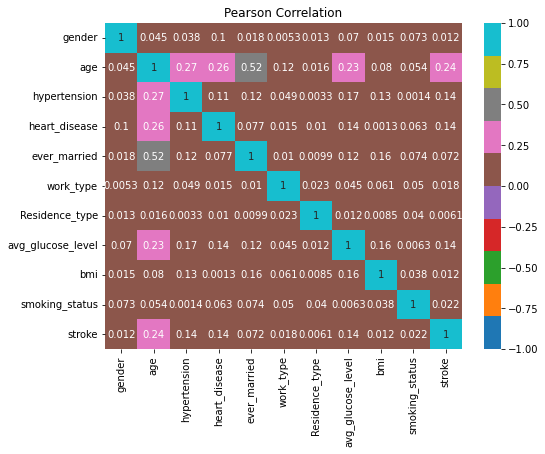

Residence_type       0.006068
bmi                  0.011673
gender               0.012467
work_type            0.018170
smoking_status       0.022042
ever_married         0.071691
heart_disease        0.138553
avg_glucose_level    0.140453
hypertension         0.143647
age                  0.242495
stroke               1.000000
Name: stroke, dtype: float64


In [19]:
corr = data_clean.corr(method='pearson').abs()

corr.describe()
corr.head()

fig = plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='tab10', vmin=-1, vmax=+1)
plt.title('Pearson Correlation')
plt.show()

print(data_clean.corr()['stroke'].abs().sort_values())

## 6.2 Select k best

In [20]:
#independent columns
X = data_clean.iloc[:, 0:20]
#target column
y = data_clean.iloc[:, -1]

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization
featurescores = pd.concat([dfcolumns, dfscores], axis=1)
#naming the dataframe columns
featurescores.columns = ['Specs', 'Score']
#print 10 best features
print(featurescores.nlargest(13, 'Score'))

                Specs        Score
10             stroke  3246.000000
1                 age  1471.290618
7   avg_glucose_level  1419.401631
2        hypertension    62.274874
3       heart_disease    61.814504
4        ever_married     4.250464
9      smoking_status     1.603412
8                 bmi     0.820193
5           work_type     0.257849
0              gender     0.208108
6      Residence_type     0.064252


## 6.3 Feature importance

[0.00150367 0.01778132 0.00769574 0.00601668 0.00209777 0.00289335
 0.00187605 0.01018854 0.00560639 0.00308995 0.94125055]


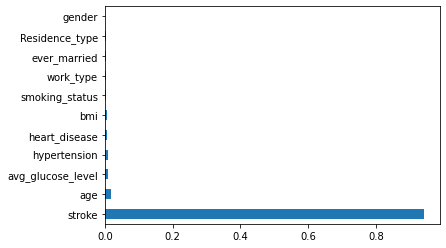

In [21]:
#independent columns
X = data_clean.iloc[:, 0:20]
#target column
y = data_clean.iloc[:, -1]

model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)  #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(13).plot(kind='barh')
plt.show()

## 6.4 Correlation matrix with heatmap

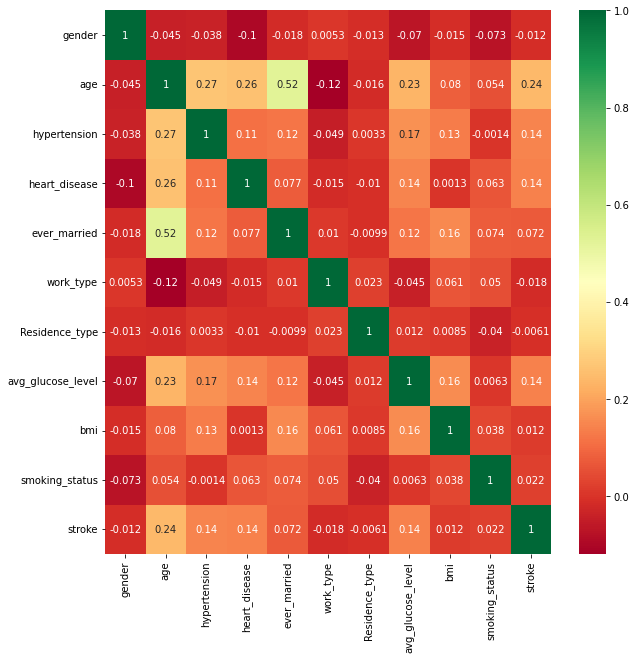

In [22]:
#independent columns
X = data_clean.iloc[:, 0:20]
#target column
y = data_clean.iloc[:, -1]

#get correlations of each features in dataset
corrmatrix = data_clean.corr()
top_corr_features = corrmatrix.index
plt.figure(figsize=(10, 10))

#plot heat map
g = sns.heatmap(data_clean[top_corr_features].corr(), annot=True, cmap="RdYlGn")

# 7. Different models to train and see which preforms the best

## 7.1 GBM (Gradient boosting)

### 7.1.1 LightGBM

[1]	training's binary_logloss: 0.135412	valid_0's binary_logloss: 0.210152
[2]	training's binary_logloss: 0.12665	valid_0's binary_logloss: 0.208347
[3]	training's binary_logloss: 0.119794	valid_0's binary_logloss: 0.204264
[4]	training's binary_logloss: 0.114438	valid_0's binary_logloss: 0.20311
[5]	training's binary_logloss: 0.109778	valid_0's binary_logloss: 0.202721
[6]	training's binary_logloss: 0.105433	valid_0's binary_logloss: 0.201093
[7]	training's binary_logloss: 0.102172	valid_0's binary_logloss: 0.199978
[8]	training's binary_logloss: 0.0985691	valid_0's binary_logloss: 0.199135
[9]	training's binary_logloss: 0.0936263	valid_0's binary_logloss: 0.199922
[10]	training's binary_logloss: 0.0896053	valid_0's binary_logloss: 0.201076
[11]	training's binary_logloss: 0.0848282	valid_0's binary_logloss: 0.202946
[12]	training's binary_logloss: 0.0808623	valid_0's binary_logloss: 0.204551
[13]	training's binary_logloss: 0.0786126	valid_0's binary_logloss: 0.206519
[14]	training's b

/home/emcy/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


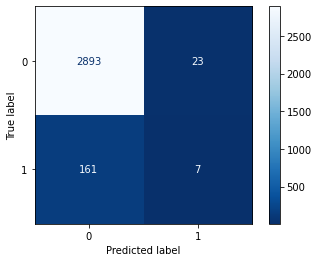

In [23]:
stroke_lgb = data_clean
stroke_lgb.head()

# define input and output features to train model
X = stroke_lgb.drop(['stroke'], axis=1)
y = stroke_lgb.stroke

# train and test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=42)

model_lgb = lgb.LGBMClassifier(learning_rate=0.08, max_depth=-3, random_state=42)
model_lgb.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)],
              eval_metric='logloss')

y_pred = model_lgb.predict(X_test)

# Save accuracy score for summary display in section 8
acc_lgb = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, model_lgb.predict(X_test)))
print("Training accuracy {:4f}".format(model_lgb.score(X_train, y_train)))
print("Testing accuracy {:4f}".format(model_lgb.score(X_test, y_test)))
print("-------------------------------------------------")

#lgb.plot_importance(model_lgb)
#lgb.plot_metric(model_lgb)
metrics.plot_confusion_matrix(model_lgb, X_test, y_test, cmap='Blues_r')

print("the f1 score for lightGBM is :", (f1_score(y_test, y_pred, average="macro")))
print("the precision score is :", (precision_score(y_test, y_pred, average="macro")))
print("the recall score is :", (recall_score(y_test, y_pred, average="macro")))
print("LightGBM Accuracy: %.3f" % metrics.accuracy_score(y_test, y_pred))
print("-------------------------------------------------")
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

### 7.1.2 GBM

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2916
           1       0.94      0.20      0.33       168

    accuracy                           0.96      3084
   macro avg       0.95      0.60      0.65      3084
weighted avg       0.96      0.96      0.94      3084

Training accuracy 0.958045
Testing accuracy 0.955577
-------------------------------------------------
the f1 score for Gradient boosting Classifier is : 0.6510779217025423
the precision score is : 0.949290165393806
the recall score is : 0.597871350186165
GBM Accuracy is: 0.956
-------------------------------------------------
Number of mislabeled points out of a total 3084 points : 137


/home/emcy/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


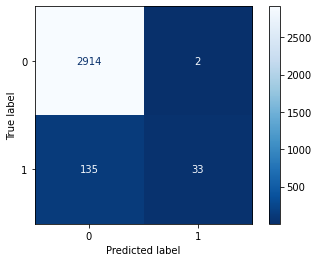

In [24]:
stroke_gbm = data_clean
stroke_gbm.head()

# define input and output features to train model
X = stroke_gbm.drop('stroke', axis=1)
y = stroke_gbm.stroke

# train and test splitting
kf = KFold(n_splits=5, random_state=42, shuffle=True)

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

model_gradient_booster = GradientBoostingClassifier(learning_rate=0.1)
model_gradient_booster.get_params()

model_gradient_booster.fit(X_train, y_train)

y_pred = model_gradient_booster.predict(X_test)

# Save accuracy score for summary display in section 8
acc_gbm = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, model_gradient_booster.predict(X_test)))
print("Training accuracy {:4f}".format(model_gradient_booster.score(X_train, y_train)))
print("Testing accuracy {:4f}".format(model_gradient_booster.score(X_test, y_test)))
print("-------------------------------------------------")

metrics.plot_confusion_matrix(model_gradient_booster, X_test, y_test, cmap='Blues_r')

print("the f1 score for Gradient boosting Classifier is :", (f1_score(y_test, y_pred, average="macro")))
print("the precision score is :", (precision_score(y_test, y_pred, average="macro")))
print("the recall score is :", (recall_score(y_test, y_pred, average="macro")))
print("GBM Accuracy is: %.3f" % metrics.accuracy_score(y_test, y_pred))
print("-------------------------------------------------")
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

## 7.1.3 GBM 2

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2435
           1       0.24      0.04      0.07       135

    accuracy                           0.94      2570
   macro avg       0.59      0.52      0.52      2570
weighted avg       0.91      0.94      0.92      2570

Training accuracy 0.987150
Testing accuracy 0.942412
-------------------------------------------------
the f1 score for GBM2 is : 0.522640562248996
the precision score is : 0.594656188605108
the recall score is : 0.518320784850559
GBM2 Accuracy is: 0.942
-------------------------------------------------
Number of mislabeled points out of a total 2570 points : 148


/home/emcy/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


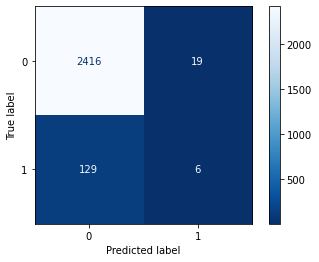

In [25]:
#anotherway of doing gbm
stroke_gbm2 = data_clean
stroke_gbm2.head()

# define input and output features to train model
X = stroke_gbm2.drop('stroke', axis=1)
y = stroke_gbm2.stroke

# train and test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42, stratify=y)

preprocessor = make_pipeline(MinMaxScaler())

model_GBMPipline = make_pipeline(preprocessor, GradientBoostingClassifier(learning_rate=0.1))
model_GBMPipline.fit(X_train, y_train)

y_proba = model_GBMPipline.predict_proba(X_test)
y_pred = np.argmax(y_proba, axis=1)

# Save accuracy score for summary display in section 8
acc_gbm2 = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, model_GBMPipline.predict(X_test)))
print("Training accuracy {:4f}".format(model_GBMPipline.score(X_train, y_train)))
print("Testing accuracy {:4f}".format(model_GBMPipline.score(X_test, y_test)))
print("-------------------------------------------------")

metrics.plot_confusion_matrix(model_GBMPipline, X_test, y_test, cmap='Blues_r')

print("the f1 score for GBM2 is :", (f1_score(y_test, y_pred, average="macro")))
print("the precision score is :", (precision_score(y_test, y_pred, average="macro")))
print("the recall score is :", (recall_score(y_test, y_pred, average="macro")))
print("GBM2 Accuracy is: %.3f" % metrics.accuracy_score(y_test, y_pred))
print("-------------------------------------------------")
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

## 7.2 Catboost

0:	learn: 0.5226529	total: 61.1ms	remaining: 1m 1s
1:	learn: 0.4287323	total: 74.8ms	remaining: 37.3s
2:	learn: 0.3397112	total: 88.6ms	remaining: 29.4s
3:	learn: 0.2946242	total: 102ms	remaining: 25.4s
4:	learn: 0.2336252	total: 121ms	remaining: 24.2s
5:	learn: 0.2023156	total: 135ms	remaining: 22.4s
6:	learn: 0.1849202	total: 149ms	remaining: 21.1s
7:	learn: 0.1740940	total: 163ms	remaining: 20.2s
8:	learn: 0.1626001	total: 176ms	remaining: 19.4s
9:	learn: 0.1482344	total: 190ms	remaining: 18.8s
10:	learn: 0.1340549	total: 204ms	remaining: 18.3s
11:	learn: 0.1241608	total: 217ms	remaining: 17.9s
12:	learn: 0.1161772	total: 231ms	remaining: 17.5s
13:	learn: 0.1070921	total: 244ms	remaining: 17.2s
14:	learn: 0.0992767	total: 258ms	remaining: 16.9s
15:	learn: 0.0917837	total: 272ms	remaining: 16.7s
16:	learn: 0.0862687	total: 285ms	remaining: 16.5s
17:	learn: 0.0826690	total: 299ms	remaining: 16.3s
18:	learn: 0.0785828	total: 313ms	remaining: 16.1s
19:	learn: 0.0760439	total: 326ms	rema

/home/emcy/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


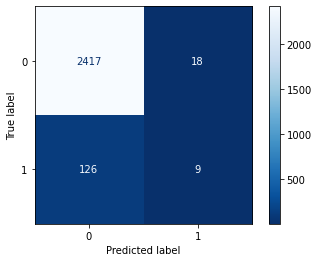

In [26]:
stroke_catb = data_clean
stroke_catb.head()

# define input and output features to train model
X = stroke_catb.drop('stroke', axis=1)
y = stroke_catb.stroke

# train and test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42, stratify=y)

preprocessor = make_pipeline(MinMaxScaler())
model_CatPipeline = make_pipeline(preprocessor, CatBoostClassifier(iterations=1000, loss_function='MultiClass',
                                                                   bootstrap_type="Bayesian",
                                                                   eval_metric='MultiClass',
                                                                   leaf_estimation_iterations=100,
                                                                   random_strength=0.5,
                                                                   depth=7,
                                                                   l2_leaf_reg=5,
                                                                   learning_rate=0.1,
                                                                   bagging_temperature=0.5,
                                                                   allow_writing_files=False))
model_CatPipeline.fit(X_train, y_train)

y_proba = model_CatPipeline.predict_proba(X_test)
y_pred = np.argmax(y_proba, axis=1)

# Save accuracy score for summary display in section 8
acc_catboost = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, model_CatPipeline.predict(X_test)))
print("Training accuracy {:4f}".format(model_CatPipeline.score(X_train, y_train)))
print("Testing accuracy {:4f}".format(model_CatPipeline.score(X_test, y_test)))
print("-------------------------------------------------")

metrics.plot_confusion_matrix(model_CatPipeline, X_test, y_test, cmap='Blues_r')

print("the f1 score for CATb is :", (f1_score(y_test, y_pred, average="macro")))
print("the precision score is :", (precision_score(y_test, y_pred, average="macro")))
print("the recall score is :", (recall_score(y_test, y_pred, average="macro")))
print("CatBoost Accuracy is :  %.3f" % metrics.accuracy_score(y_test, y_pred))
print("-------------------------------------------------")
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

## 7.3 ADAboost

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2435
           1       0.19      0.10      0.13       135

    accuracy                           0.93      2570
   macro avg       0.57      0.54      0.55      2570
weighted avg       0.91      0.93      0.92      2570

Training accuracy 0.976636
Testing accuracy 0.929183
-------------------------------------------------


/home/emcy/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


the f1 score for ADA is : 0.5482082488167681
the precision score is : 0.5690848363393454
the recall score is : 0.5393261845007224
Adaboost Accuracy is : 0.929
-------------------------------------------------
Number of mislabeled points out of a total 2570 points : 182


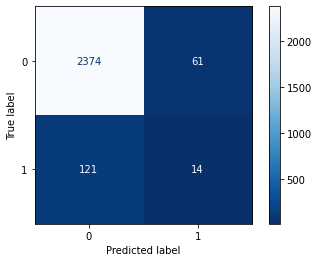

In [27]:
stroke_adab = data_clean
stroke_adab.head()

# define input and output features to train model
X = stroke_adab.drop('stroke', axis=1)
y = stroke_adab.stroke

# train and test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42, stratify=y)

preprocessor = make_pipeline(MinMaxScaler())
model_AdaPipeline = make_pipeline(preprocessor, AdaBoostClassifier(n_estimators=200, learning_rate=1.4))

model_AdaPipeline.fit(X_train, y_train)

y_proba = model_AdaPipeline.predict_proba(X_test)
y_pred = np.argmax(y_proba, axis=1)

# Save accuracy score for summary display in section 8
acc_adaboost = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, model_AdaPipeline.predict(X_test)))
print("Training accuracy {:4f}".format(model_AdaPipeline.score(X_train, y_train)))
print("Testing accuracy {:4f}".format(model_AdaPipeline.score(X_test, y_test)))
print("-------------------------------------------------")

metrics.plot_confusion_matrix(model_AdaPipeline, X_test, y_test, cmap='Blues_r')

print("the f1 score for ADA is :", (f1_score(y_test, y_pred, average="macro")))
print("the precision score is :", (precision_score(y_test, y_pred, average="macro")))
print("the recall score is :", (recall_score(y_test, y_pred, average="macro")))
print("Adaboost Accuracy is : %.3f" % metrics.accuracy_score(y_test, y_pred))
print("-------------------------------------------------")
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

## 7.4 Logistic regression

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2435
           1       0.05      1.00      0.10       135

    accuracy                           0.05      2570
   macro avg       0.03      0.50      0.05      2570
weighted avg       0.00      0.05      0.01      2570

Training accuracy 0.052570
Testing accuracy 0.052529
-------------------------------------------------
the f1 score for logistic regression is : 0.5075213183865095
the precision score is : 0.6885346413243408
the recall score is : 0.5102897558749715
Logistic Regression Accuracy is : 0.947
-------------------------------------------------
Number of mislabeled points out of a total 2570 points : 136


/home/emcy/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/emcy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/emcy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/emcy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with n

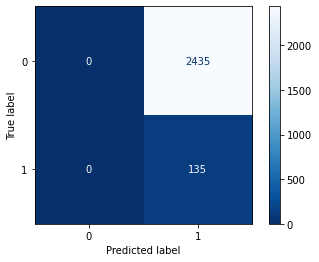

In [28]:
stroke_lr = data_clean
stroke_lr.head()

# define input and output features to train model
X = stroke_lr.drop('stroke', axis=1)
y = stroke_lr.stroke

# train and test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42, stratify=y)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Create an instance of LogisticRegression classifier
model_lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')

# Fit the model
model_lr.fit(X_train_std, y_train)

# Create the predictions
y_pred = model_lr.predict(X_test_std)

# Save accuracy score for summary display in section 8
acc_logreg = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, model_lr.predict(X_test)))
print("Training accuracy {:4f}".format(model_lr.score(X_train, y_train)))
print("Testing accuracy {:4f}".format(model_lr.score(X_test, y_test)))
print("-------------------------------------------------")

metrics.plot_confusion_matrix(model_lr, X_test, y_test, cmap='Blues_r')

print("the f1 score for logistic regression is :", (f1_score(y_test, y_pred, average="macro")))
print("the precision score is :", (precision_score(y_test, y_pred, average="macro")))
print("the recall score is :", (recall_score(y_test, y_pred, average="macro")))
print("Logistic Regression Accuracy is : %.3f" % metrics.accuracy_score(y_test, y_pred))
print("-------------------------------------------------")
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

## 7.5 random forest

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2435
           1       0.17      0.01      0.01       135

    accuracy                           0.95      2570
   macro avg       0.56      0.50      0.49      2570
weighted avg       0.91      0.95      0.92      2570

Training accuracy 0.998832
Testing accuracy 0.945914
-------------------------------------------------
the f1 score for Random Forest Classifier is : 0.4931894180254491
the precision score is : 0.5572022880915237
the recall score is : 0.5026770096585291
Random Forest Accuracy is : 0.946
-------------------------------------------------
Number of mislabeled points out of a total 2570 points : 139


/home/emcy/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


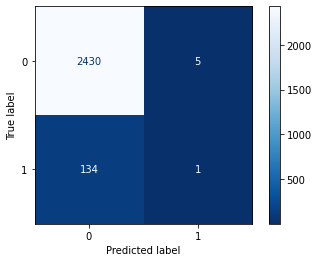

In [29]:
stroke_rf = data_clean
stroke_rf.head()

# define input and output features to train model
X = stroke_rf.drop(['stroke'], axis=1)
y = stroke_rf.stroke

# train and test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42, stratify=y)

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)

# Save accuracy score for summary display in section 8
acc_randomforest = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, model_rf.predict(X_test)))
print("Training accuracy {:4f}".format(model_rf.score(X_train, y_train)))
print("Testing accuracy {:4f}".format(model_rf.score(X_test, y_test)))
print("-------------------------------------------------")

metrics.plot_confusion_matrix(model_rf, X_test, y_test, cmap='Blues_r')

print("the f1 score for Random Forest Classifier is :", (f1_score(y_test, y_pred, average="macro")))
print("the precision score is :", (precision_score(y_test, y_pred, average="macro")))
print("the recall score is :", (recall_score(y_test, y_pred, average="macro")))
print("Random Forest Accuracy is : %.3f" % metrics.accuracy_score(y_test, y_pred))
print("-------------------------------------------------")
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

## 7.6 k-nearest neighbour

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2445
           1       0.31      0.03      0.06       125

    accuracy                           0.95      2570
   macro avg       0.63      0.51      0.52      2570
weighted avg       0.92      0.95      0.93      2570

Training accuracy 0.938084
Testing accuracy 0.949416
-------------------------------------------------


/home/emcy/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


the f1 score for KNN is : 0.5159907051672085
the precision score is : 0.6301856141511988
the recall score is : 0.514159509202454
KNN accuracy is : 0.949
-------------------------------------------------
Number of mislabeled points out of a total 2570 points : 130


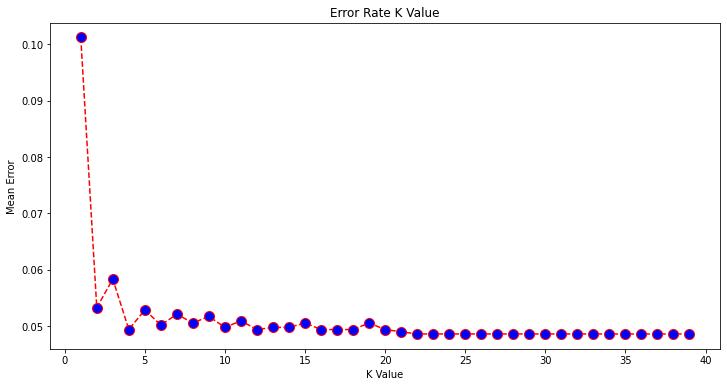

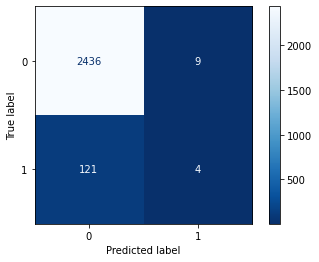

In [30]:
stroke_knn = data_clean
stroke_knn.head()

# define input and output features to train model
X = stroke_knn.drop(['stroke'], axis=1)
y = stroke_knn.stroke

# train and test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model_knn = KNeighborsClassifier(n_neighbors=8)
model_knn.fit(X_train, y_train)

y_pred = model_knn.predict(X_test)

# Save accuracy score for summary display in section 8
acc_knn = metrics.accuracy_score(y_test, y_pred)

error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

print(metrics.classification_report(y_test, model_knn.predict(X_test)))
print("Training accuracy {:4f}".format(model_knn.score(X_train, y_train)))
print("Testing accuracy {:4f}".format(model_knn.score(X_test, y_test)))
print("-------------------------------------------------")

metrics.plot_confusion_matrix(model_knn, X_test, y_test, cmap='Blues_r')

print("the f1 score for KNN is :", (f1_score(y_test, y_pred, average="macro")))
print("the precision score is :", (precision_score(y_test, y_pred, average="macro")))
print("the recall score is :", (recall_score(y_test, y_pred, average="macro")))
print("KNN accuracy is : %.3f" % metrics.accuracy_score(y_test, y_pred))
print("-------------------------------------------------")
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

## 7.7 support vector machine

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2916
           1       0.00      0.00      0.00       168

    accuracy                           0.95      3084
   macro avg       0.47      0.50      0.49      3084
weighted avg       0.89      0.95      0.92      3084

Training accuracy 0.964912
Testing accuracy 0.945525
-------------------------------------------------
the f1 score for Support Vector machine is : 0.486
the precision score is : 0.4727626459143969
the recall score is : 0.5
Support Vector machine accuracy is : 0.946
-------------------------------------------------
Number of mislabeled points out of a total 3084 points : 168


/home/emcy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/emcy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/emcy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/emcy/.local/lib/python3.10/site-packa

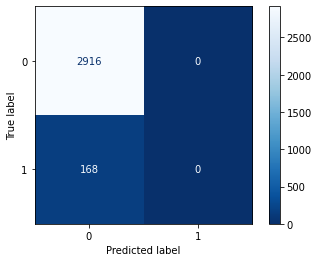

In [31]:
stroke_svm = data_clean
stroke_svm.head()

# define input and output features to train model
X = stroke_svm.drop(['stroke'], axis=1)
y = stroke_svm.stroke

# train and test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=42)

model_SVM = SVC(random_state=0, probability=True, C=80.0, gamma=0.00002, kernel='rbf')
model_SVM.fit(X_train, y_train)

y_pred = model_SVM.predict(X_test)

# Save accuracy score for summary display in section 8
acc_svm = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, model_SVM.predict(X_test)))
print("Training accuracy {:4f}".format(model_SVM.score(X_train, y_train)))
print("Testing accuracy {:4f}".format(model_SVM.score(X_test, y_test)))
print("-------------------------------------------------")

metrics.plot_confusion_matrix(model_SVM, X_test, y_test, cmap='Blues_r')

print("the f1 score for Support Vector machine is :", (f1_score(y_test, y_pred, average="macro")))
print("the precision score is :", (precision_score(y_test, y_pred, average="macro")))
print("the recall score is :", (recall_score(y_test, y_pred, average="macro")))
print("Support Vector machine accuracy is : %.3f" % metrics.accuracy_score(y_test, y_pred))
print("-------------------------------------------------")
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

## 7.8 Decision tree

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       817
           1       0.11      0.10      0.10        40

    accuracy                           0.92       857
   macro avg       0.53      0.53      0.53       857
weighted avg       0.92      0.92      0.92       857

Training accuracy 1.000000
Testing accuracy 0.918320
-------------------------------------------------
the f1 score for Decision tree is : 0.5298884082502665
the precision score is : 0.5306535569693465
the recall score is : 0.5291921664626683
Support Decision Tree accuracy is : 0.918
-------------------------------------------------
Number of mislabeled points out of a total 857 points : 70


/home/emcy/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


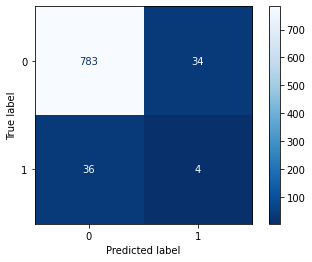

In [32]:
stroke_dt = data_clean
stroke_dt.head()

# define input and output features to train model
X = stroke_dt.drop(['stroke'], axis=1)
y = stroke_dt.stroke

# train and test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

#path = model_dt.cost_complexity_pruning_path(X_train, y_train)

y_pred = model_dt.predict(X_test)

# Save accuracy score for summary display in section 8
acc_dt = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, model_dt.predict(X_test)))
print("Training accuracy {:4f}".format(model_dt.score(X_train, y_train)))
print("Testing accuracy {:4f}".format(model_dt.score(X_test, y_test)))
print("-------------------------------------------------")

metrics.plot_confusion_matrix(model_dt, X_test, y_test, cmap='Blues_r')

print("the f1 score for Decision tree is :", (f1_score(y_test, y_pred, average="macro")))
print("the precision score is :", (precision_score(y_test, y_pred, average="macro")))
print("the recall score is :", (recall_score(y_test, y_pred, average="macro")))
print("Support Decision Tree accuracy is : %.3f" % metrics.accuracy_score(y_test, y_pred))
print("-------------------------------------------------")
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

## 7.9 Naive bayes

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2434
           1       0.16      0.39      0.23       136

    accuracy                           0.86      2570
   macro avg       0.56      0.64      0.57      2570
weighted avg       0.92      0.86      0.88      2570

Training accuracy 0.865654
Testing accuracy 0.857977
-------------------------------------------------
the f1 score for Naive Bayes is : 0.5734389402205176
the precision score is : 0.560536244949748
the recall score is : 0.636923606747547
Support Naive Bayes accuracy is : 0.858
-------------------------------------------------
Number of mislabeled points out of a total 2570 points : 365


/home/emcy/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


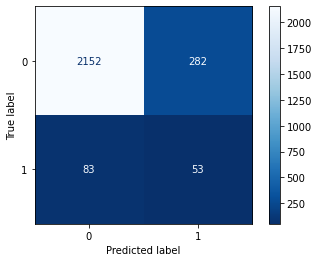

In [33]:
stroke_nb = data_clean
stroke_nb.head()

# define input and output features to train model
X = stroke_nb.drop('stroke', axis=1)
y = stroke_nb.stroke

# train and test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

model_gnb = GaussianNB()
y_pred = model_gnb.fit(X_train, y_train).predict(X_test)

# Save accuracy score for summary display in section 8
acc_nb = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, model_gnb.predict(X_test)))
print("Training accuracy {:4f}".format(model_gnb.score(X_train, y_train)))
print("Testing accuracy {:4f}".format(model_gnb.score(X_test, y_test)))
print("-------------------------------------------------")

metrics.plot_confusion_matrix(model_gnb, X_test, y_test, cmap='Blues_r')

print("the f1 score for Naive Bayes is :", (f1_score(y_test, y_pred, average="macro")))
print("the precision score is :", (precision_score(y_test, y_pred, average="macro")))
print("the recall score is :", (recall_score(y_test, y_pred, average="macro")))
print("Support Naive Bayes accuracy is : %.3f" % metrics.accuracy_score(y_test, y_pred))
print("-------------------------------------------------")
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

# 8. Displaying best model

In [34]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',
              'Random Forest', 'Decision Tree', 'LightGBM', 'GBM', 'GBM2', 'AdaBoost', 
              'CatBoost', 'Naive Bayes'],
    'Score': [acc_svm, acc_knn, acc_logreg, acc_randomforest, acc_dt, acc_lgb,
              acc_gbm, acc_gbm2, acc_adaboost, acc_catboost, acc_nb]})
models.sort_values(by='Score', ascending=False)

,Model,Score
6,GBM,0.955577
1,KNN,0.949416
2,Logistic Regression,0.947082
3,Random Forest,0.945914
0,Support Vector Machines,0.945525
9,CatBoost,0.943969
7,GBM2,0.942412
5,LightGBM,0.940337
8,AdaBoost,0.929183
4,Decision Tree,0.918320


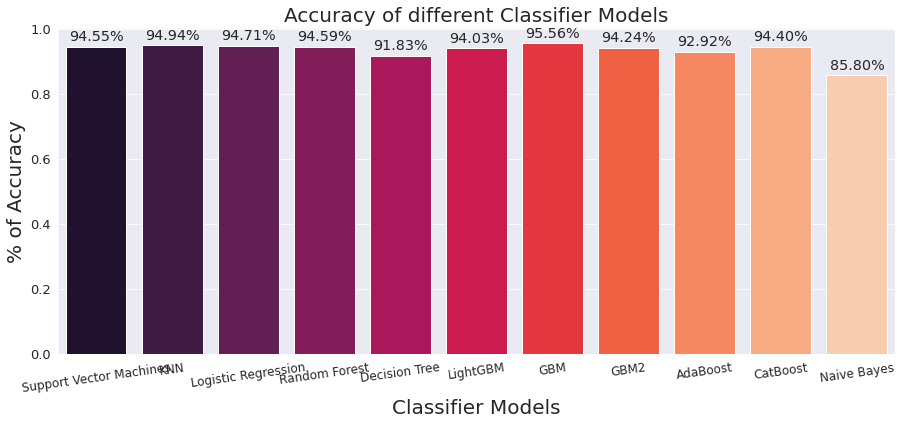

In [35]:
plt.rcParams['figure.figsize'] = 15, 6
sns.set_style("darkgrid")
ax = sns.barplot(x=models.Model, y=models.Score, palette="rocket", saturation=1.5)
plt.xlabel("Classifier Models", fontsize=20)
plt.ylabel("% of Accuracy", fontsize=20)
plt.title("Accuracy of different Classifier Models", fontsize=20)
plt.xticks(fontsize=12, horizontalalignment='center', rotation=8)
plt.yticks(fontsize=13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.2%}', (x + width / 2, y + height * 1.02), ha='center', fontsize='x-large')
plt.show()

Best model for this dataset in this case is gradient boosting